# Bird image classification
### Ariane ALIX
### 26/11/2019

In [64]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import time
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm
import sklearn
import numpy as np
import scipy
from torch.autograd import Variable
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

In [66]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Object Reco clean')

Mounted at /content/drive


In [67]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder

### Validation set loaders

In [0]:
from data_ResNet18 import * #same for 18 and 50

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset/val_images',
                         transform=data_transforms),
    batch_size=1, shuffle=False, num_workers=0)

### True labels

In [0]:
true_labels=np.zeros((103,))

i=0
for data, target in val_loader:
    true_labels[i]=target.data.numpy()
    i+=1

## 1. Loading best models


### Model 1

In [0]:
%%capture
model1 = torchvision.models.resnet18(pretrained=True)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, 20)

model1.load_state_dict(torch.load('experiment_ResNet18_adam/best_model.pth'))

model1.cuda()

### Model 2

In [0]:
%%capture
model2 = torchvision.models.resnet18(pretrained=True)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 20)

model2.load_state_dict(torch.load('experiment_ResNet18_adam_2/best_model.pth'))

model2.cuda()

### Model 3

In [0]:
%%capture
model3 = torchvision.models.resnet50(pretrained=True)
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, 20)

model3.load_state_dict(torch.load('experiment_ResNet50/best_model.pth'))

model3.cuda()

## 2. Computing outputs and normalizing them

In [0]:
def normalize(x):
    y=np.zeros(x.shape)
    for i in range(x.shape[0]):
        y[i,:]=(x[i,:]-np.min(x[i,:]))/np.sum(x[i,:]-np.min(x[i,:]))
    
    return y

### Model 1

In [0]:
model1.eval()
output1=np.zeros((103,20))

i=0
for data, target in val_loader:
    data, target = data.cuda(), target.cuda()
    score = model1(data)
    output1[i,:]=score.cpu().data.numpy()[0]
    i+=1
    
output1=normalize(output1)

### Model 2

In [0]:
model2.eval()
output2=np.zeros((103,20))

i=0
for data, target in val_loader:
    data, target = data.cuda(), target.cuda()
    score = model2(data)
    output2[i,:]=score.cpu().data.numpy()[0]
    i+=1

output2=normalize(output2)

### Model 3

In [0]:
model3.eval()
output3=np.zeros((103,20))

i=0
model3.to('cpu')
for data, target in val_loader:
    score = model3(data)
    output3[i,:]=score.cpu().data.numpy()[0]
    i+=1
model3.cuda()

output3=normalize(output3)

## 3. Checking accuracy of models and combined model

In [0]:
def visualize_model(dataloader, model, num_images=16):
    cnt = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
       
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            plt.figure(figsize=(5,5))
            
            inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            plt.imshow(inp)
        
            plt.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            plt.show()
            
            cnt += 1
            if cnt == num_images:
                return
    

### Model 1

In [78]:
#Result for model 1
label1=np.argmax(output1,axis=1)
print(np.sum(label1==true_labels)/103)

0.8058252427184466


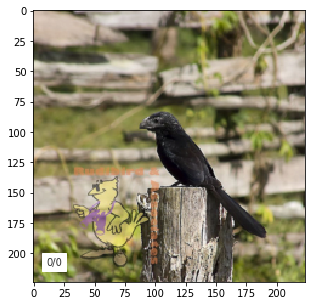

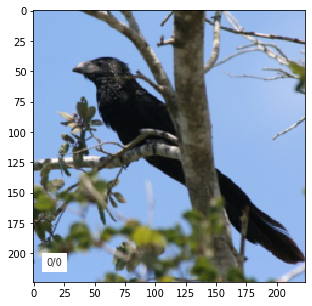

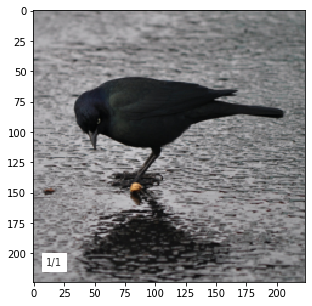

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


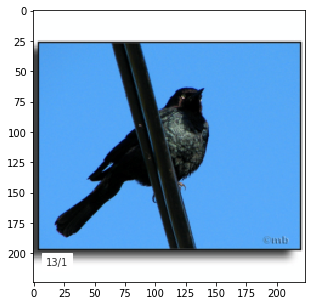

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


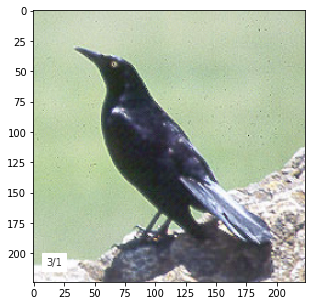

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


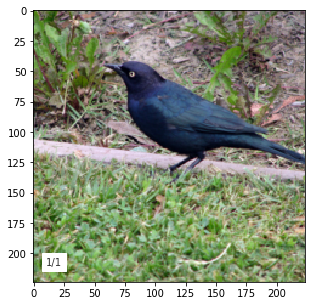

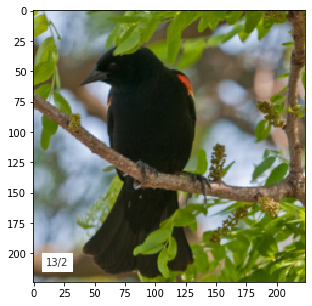

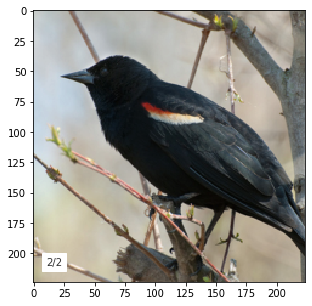

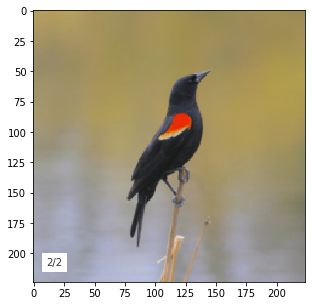

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


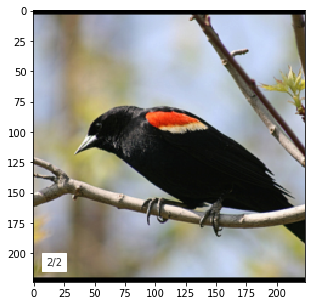

In [79]:
visualize_model(val_loader, model1, num_images=10)

### Model 2

In [80]:
#Result for model 2
label2=np.argmax(output2,axis=1)
print(np.sum(label2==true_labels)/103)

0.8155339805825242


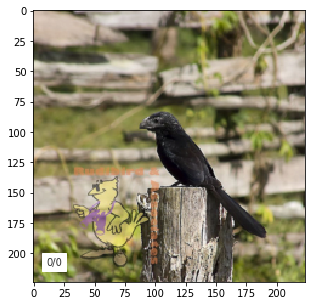

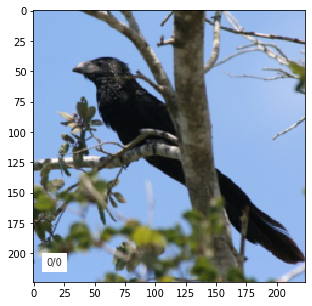

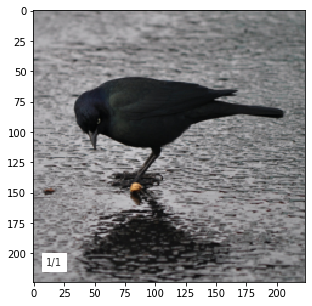

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


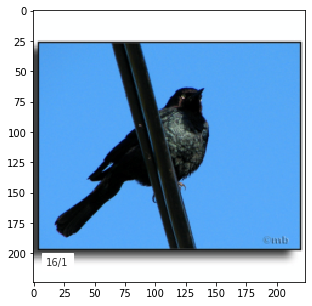

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


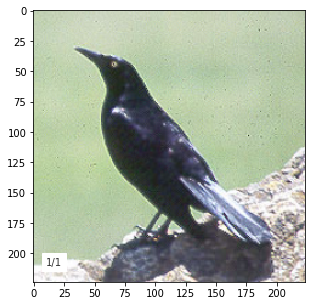

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


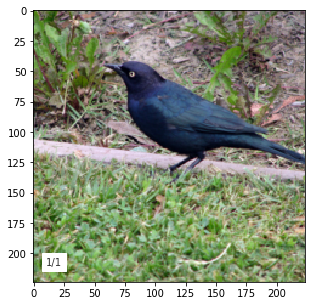

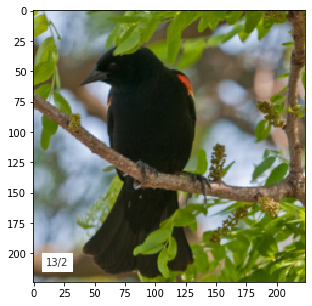

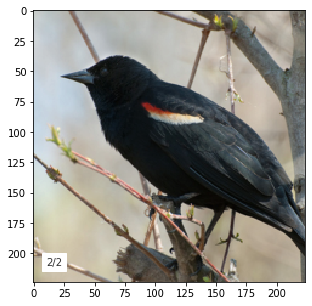

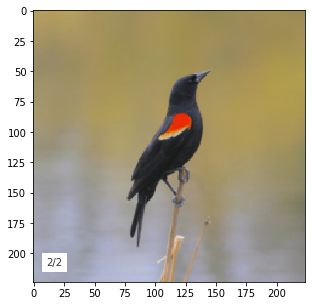

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


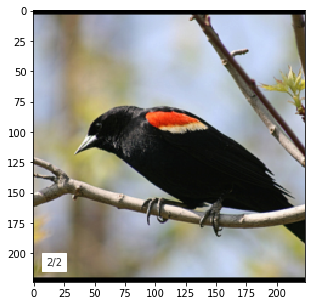

In [81]:
visualize_model(val_loader, model2, num_images=10)

### Model 3

In [82]:
#Result for model 3
label3=np.argmax(output3,axis=1)
print(np.sum(label3==true_labels)/103)

0.8446601941747572


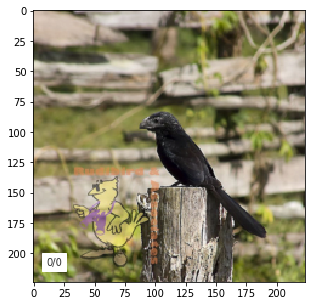

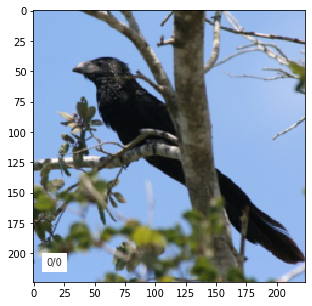

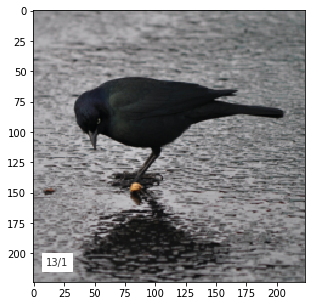

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


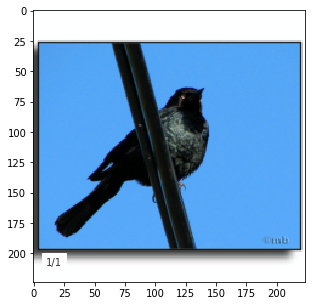

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


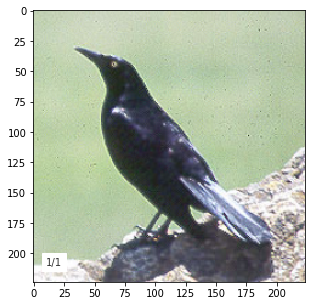

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


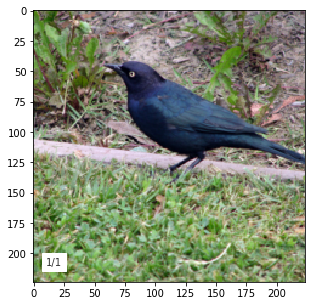

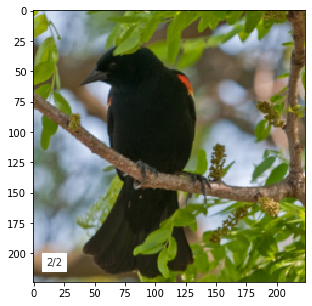

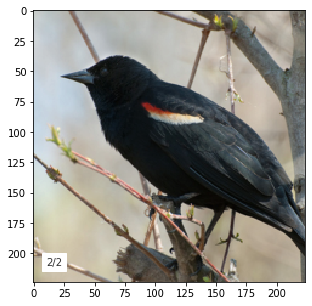

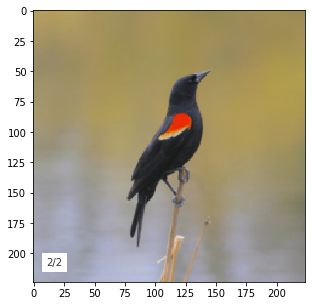

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


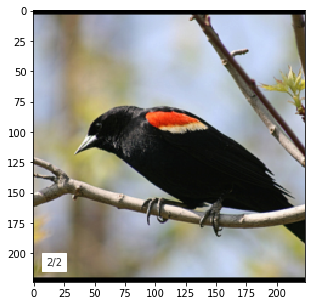

In [85]:
visualize_model(val_loader, model3, num_images=10)

### Combinations of the models to increase stability


In [83]:
#Combined:
label_combined=np.argmax(output1+output2+output3,axis=1)
print(np.sum(label_combined==true_labels)/103)

0.8737864077669902


In [84]:
best_score=0.84
for w1 in range(1,100):
    for w2 in range(1,100):
        for w3 in range(1,100):
            label_combined=np.argmax(w1*output1+w2*output2+w3*output3,axis=1)
            score=np.sum(label_combined==true_labels)/103
            if score>best_score :
                print('New best score :',score)
                print('With weights :',w1,w2,w3,'\n')
                best_score=score

New best score : 0.8737864077669902
With weights : 1 1 1 

New best score : 0.883495145631068
With weights : 1 5 2 

New best score : 0.8932038834951457
With weights : 4 1 2 



### Using the weights to generate a new prediction for the test dataset, with the models trained on the full labeled dataset augmented


In [0]:
%%capture
model_1 = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_1.fc.in_features
model_1.fc = nn.Linear(num_ftrs, 20)

model_1.load_state_dict(torch.load('experiment_ResNet18_adam_full/best_model.pth'))

model_1.cuda()

In [0]:
%%capture
model_2 = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_2.fc.in_features
model_2.fc = nn.Linear(num_ftrs, 20)

model_2.load_state_dict(torch.load('experiment_ResNet18_adam_2_full/best_model.pth'))

model_2.cuda()

In [0]:
%%capture
model_3 = torchvision.models.resnet50(pretrained=True)
num_ftrs = model_3.fc.in_features
model_3.fc = nn.Linear(num_ftrs, 20)

model_3.load_state_dict(torch.load('experiment_ResNet50_full/best_model.pth'))

model_3.cuda()

In [98]:
from data_ResNet18 import data_transforms

test_dir = 'bird_dataset/test_images/mistery_category'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


output_file = open('Results/combined_1.csv', "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = data_transforms(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        data=data.cuda()

        model_1.eval()
        output_1 = model_1(data).cpu().data.numpy()[0]
        model_2.eval()
        output_2 = model_2(data).cpu().data.numpy()[0]
        model_3.eval()
        output_3 = model_3(data).cpu().data.numpy()[0]

        pred = np.argmax(4*output_1+output_2+2*output_3)
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote 'Results/combined_1.csv', you can upload this file to the kaggle competition website")
        




  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 2/517 [00:00<00:31, 16.26it/s]

  1%|          | 4/517 [00:00<00:31, 16.44it/s]

  1%|          | 6/517 [00:00<00:30, 16.50it/s]

  2%|▏         | 8/517 [00:00<00:30, 16.83it/s]

  2%|▏         | 10/517 [00:00<00:28, 17.54it/s]

  2%|▏         | 12/517 [00:00<00:28, 17.99it/s]

  3%|▎         | 14/517 [00:00<00:27, 18.48it/s]

  3%|▎         | 16/517 [00:00<00:26, 18.76it/s]

  4%|▎         | 19/517 [00:01<00:25, 19.61it/s]

  4%|▍         | 22/517 [00:01<00:24, 20.42it/s]

  5%|▍         | 25/517 [00:01<00:23, 20.84it/s]

  5%|▌         | 28/517 [00:01<00:23, 21.20it/s]

  6%|▌         | 31/517 [00:01<00:22, 21.81it/s]

  7%|▋         | 34/517 [00:01<00:21, 22.24it/s]

  7%|▋         | 37/517 [00:01<00:21, 22.60it/s]

  8%|▊         | 40/517 [00:01<00:21, 22.62it/s]

  8%|▊         | 43/517 [00:02<00:20, 22.78it/s]

  9%|▉         | 46/517 [00:02<00:20, 22.77it/s]

  9%|▉         | 49/517 [00:02<00:20, 22.79it/s]

 10%|█     

Succesfully wrote 'Results/combined_1.csv', you can upload this file to the kaggle competition website
